In [20]:
# 1.Defining Problem Statement and Analysing basic metrics
import pandas as pd

data = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/000/940/original/netflix.csv')
print("Rows, Columns:", data.shape)
print("-------------")
print("Columns:", data.columns.tolist())
print("-------------")
print(data.head(3))

Rows, Columns: (8807, 12)
-------------
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']
-------------
  show_id     type                 title         director  \
0      s1    Movie  Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show         Blood & Water              NaN   
2      s3  TV Show             Ganglands  Julien Leclercq   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021          2021  TV-MA   1 Season   

                                      

In [24]:
# Observations on the shape of data, data types of all the attributes, conversion of categorical attributes to 'category' (If required), missing value detection, statistical summary
# Data types and missing values
data.info()
missing = data.isna().sum().sort_values(ascending=False)
print("Missing values:\n", missing[missing>0])

# Convert categorical-like columns
for c in ['type','rating']:
    data[c] = data[c].astype('category')

# Summary stats
print("\nSummary stats")
print(data.describe(include='all').T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   show_id       8807 non-null   object  
 1   type          8807 non-null   category
 2   title         8807 non-null   object  
 3   director      6173 non-null   object  
 4   cast          7982 non-null   object  
 5   country       7976 non-null   object  
 6   date_added    8797 non-null   object  
 7   release_year  8807 non-null   int64   
 8   rating        8803 non-null   category
 9   duration      8804 non-null   object  
 10  listed_in     8807 non-null   object  
 11  description   8807 non-null   object  
dtypes: category(2), int64(1), object(9)
memory usage: 706.2+ KB
Missing values:
 director      2634
country        831
cast           825
date_added      10
rating           4
duration         3
dtype: int64

Summary stats
               count unique  \
show_id         8807  

In [27]:
# 3. Non-Graphical Analysis: Value counts and unique attributes
# Unique counts
print("Unique values per column:\n", data.nunique())

# Value counts
print("\nType counts:\n", data['type'].value_counts())
# Explode helper (use earlier explode_col or use inline)
def explode_col(data, col):
    s = data.dropna(subset=[col]).copy()
    s[col] = s[col].astype(str)
    s[col] = s[col].str.split(',')
    s = s.explode(col)
    s[col] = s[col].str.strip()
    return s

genres = explode_col(data, 'listed_in')
countries = explode_col(data, 'country')
cast = explode_col(data, 'cast')
directors = explode_col(data, 'director')

print("\nTop genres:\n", genres['listed_in'].value_counts().head(10))
print("\nTop countries:\n", countries['country'].value_counts().head(10))
print("\nTop actors:\n", cast['cast'].value_counts().head(10))
print("\nTop directors:\n", directors['director'].value_counts().head(10))


Unique values per column:
 show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

Type counts:
 type
Movie      6131
TV Show    2676
Name: count, dtype: int64

Top genres:
 listed_in
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: count, dtype: int64

Top countries:
 country
United States     3690
India             1046
United Kingdom     806
Canada             445
France             393
Japan              318
Spain              232
South Korea        231
Germany            226
Mexico            

In [29]:
# 4.Visual Analysis — pre-processing + univariate & bivariate

# Clean & convert date fields
# Create 'date_added' as datetime and extract year/month/day
data['date_added'] = pd.to_datetime(data['date_added'], errors='coerce')
data['added_year'] = data['date_added'].dt.year
data['added_month'] = data['date_added'].dt.month
# cast release_year to int if not already
data['release_year'] = pd.to_numeric(data['release_year'], errors='coerce').astype('Int64')

# Clean duration - separate minutes vs seasons
# Example: "90 min" or "3 Seasons"
data['duration_raw'] = data['duration']
data['duration_type'] = data['duration'].str.extract(r'([A-Za-z]+)$')  # 'min' or 'Seasons' or 'Season'
data['duration_val'] = data['duration'].str.extract(r'(\d+)').astype('float')
# normalize
data['duration_type'] = data['duration_type'].str.replace('Seasons','Season', regex=False)




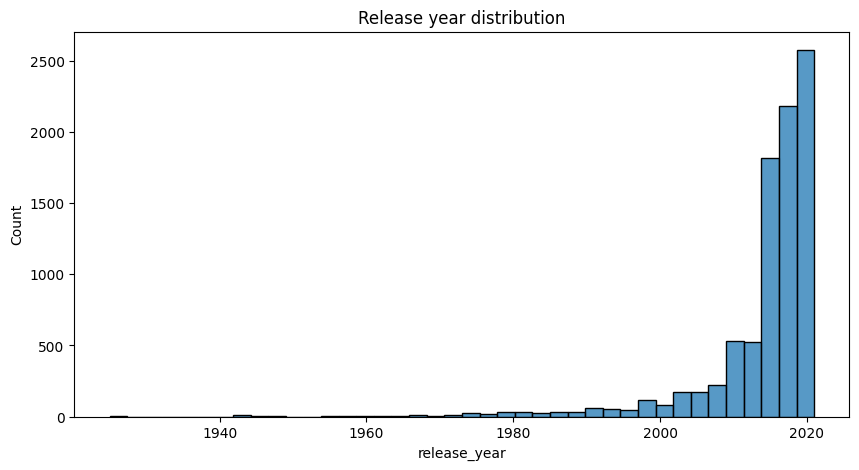

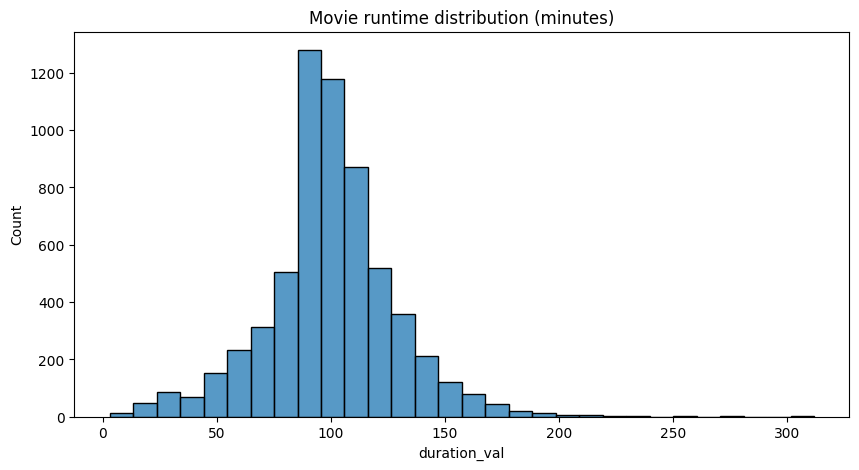

/tmp/ipython-input-327962782.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  annual = data.groupby(['added_year','type']).size().reset_index(name='count').dropna()


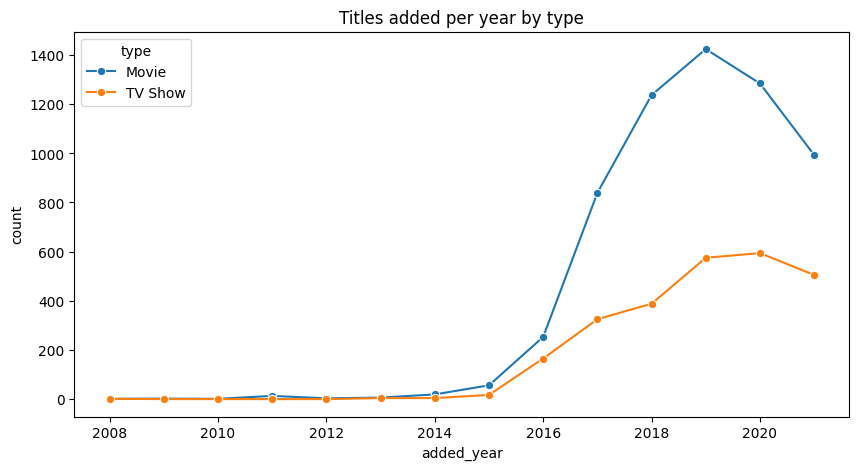

In [30]:
# 4.1 Continuous variables — Distplot / Histogram / Countplot
import matplotlib.pyplot as plt, seaborn as sns

plt.rcParams['figure.figsize']=(10,5)
# Release year histogram
sns.histplot(data['release_year'].dropna(), bins=40)
plt.title('Release year distribution');
plt.show()

# Movie runtime distribution (after extracting duration_val & type)
movies = data[data['type']=='Movie']
sns.histplot(movies[movies['duration_type']=='min']['duration_val'].dropna(), bins=30)
plt.title('Movie runtime distribution (minutes)');
plt.show()

# Titles added per year (by type)
data['added_year'] = pd.to_datetime(data['date_added'], errors='coerce').dt.year
annual = data.groupby(['added_year','type']).size().reset_index(name='count').dropna()
sns.lineplot(data=annual, x='added_year', y='count', hue='type', marker='o')
plt.title('Titles added per year by type');
plt.show()



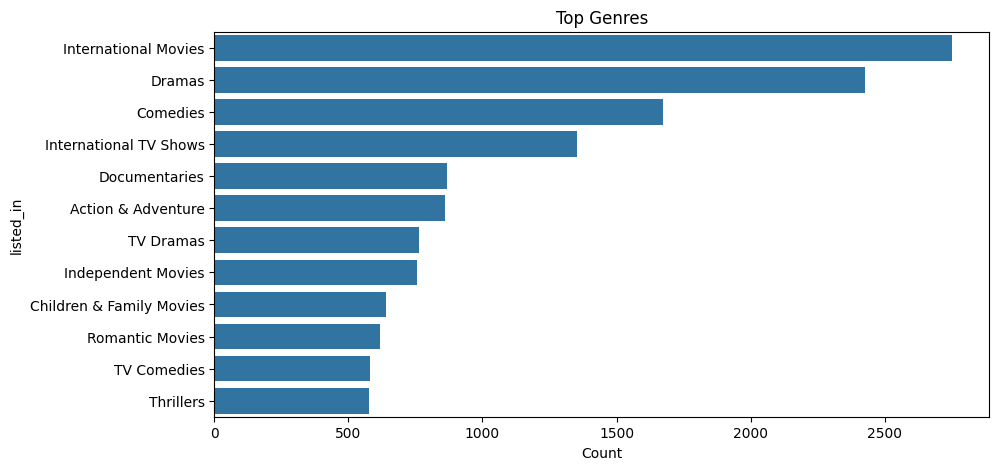

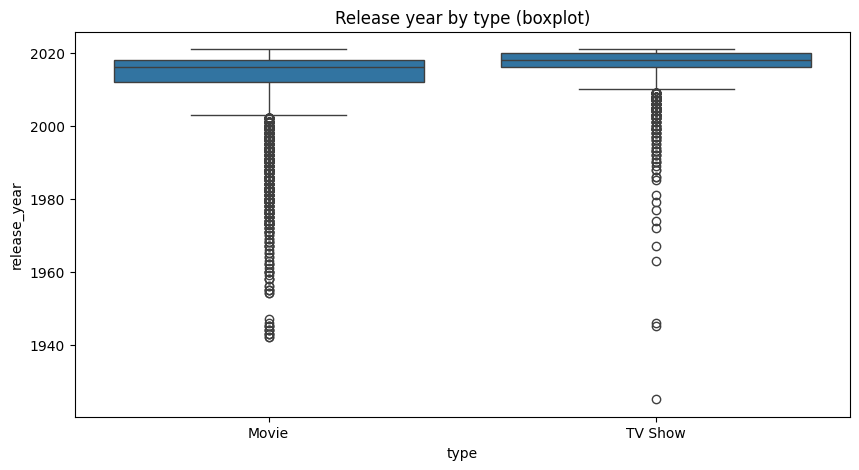

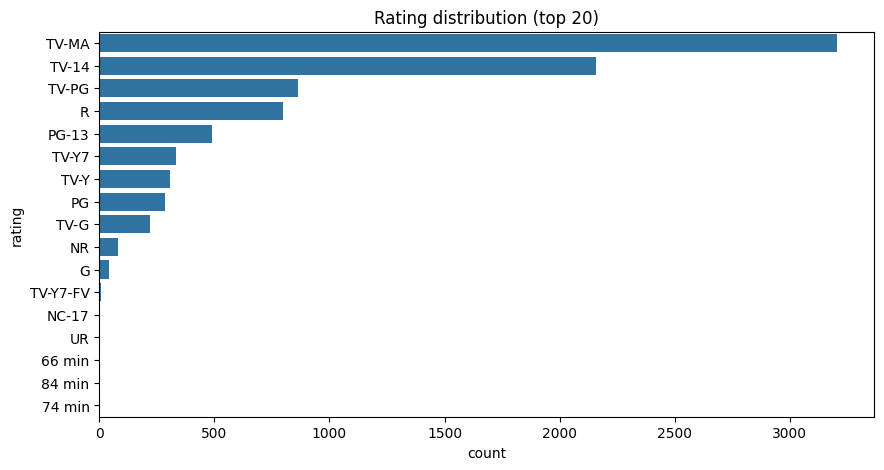

In [31]:
# 4.2 Categorical variables — Boxplot / Countplot
# Top genres barplot (countplot)
top_genres = genres['listed_in'].value_counts().head(12).index
sns.countplot(y=genres[genres['listed_in'].isin(top_genres)]['listed_in'], order=top_genres)
plt.title('Top Genres'); plt.xlabel('Count');
plt.show()

# Boxplot: release_year by type (shows spread)
sns.boxplot(data=data.dropna(subset=['release_year']), x='type', y='release_year')
plt.title('Release year by type (boxplot)');
plt.show()

# Ratings distribution (count)
sns.countplot(y=data['rating'].astype(str), order=data['rating'].value_counts().index[:20])
plt.title('Rating distribution (top 20)');
plt.show()


In [32]:
# 5. Missing values & outlier check
# Missing summary
missing = data.isna().sum().sort_values(ascending=False)
missing[missing>0]

# Outliers - duration > 300 or release_year outside plausible range
outliers_duration = data[data['duration_val']>300][['title','duration_raw','duration_val']].head()
outliers_year = data[(data['release_year']<1900) | (data['release_year']>pd.Timestamp.now().year)][['title','release_year']].head()
print("Duration outliers:\n", outliers_duration)
print("Year outliers:\n", outliers_year)


Duration outliers:
                            title duration_raw  duration_val
4253  Black Mirror: Bandersnatch      312 min         312.0
Year outliers:
 Empty DataFrame
Columns: [title, release_year]
Index: []


In [ ]:
# 6. Insights from analyses